In [1]:
import os
import numpy as np
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

### Counting Images

In [2]:
image_path = pathlib.Path("./data/train")
image_count = len(list(image_path.glob('*/*.png')))
print(image_count)

28709


In [4]:
data_list = tf.data.Dataset.list_files(str(image_path/'*/*'), shuffle=False)
data_list = data_list.shuffle(image_count, reshuffle_each_iteration=False)

In [5]:
for f in data_list.take(3):
    print(f.numpy())

b'data\\train\\neutral\\im795.png'
b'data\\train\\neutral\\im1041.png'
b'data\\train\\sad\\im4288.png'


### Show Classes

In [6]:
class_names = np.array([item.name for item in image_path.glob('*')])
print(class_names)

['angry' 'disgusted' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


### Splitting Validation set

In [7]:
val_size = int(image_count * 0.2)
train_ds = data_list.skip(val_size)
val_ds = data_list.take(val_size)

print(image_count - val_size)

22968


### Labelling Dataset

In [8]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [9]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.io.decode_png(img, 1)
    return img, label

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(3):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (48, 48, 1)
Label:  4
Image shape:  (48, 48, 1)
Label:  0
Image shape:  (48, 48, 1)
Label:  3


### For improving data processing

In [12]:
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).batch(32).prefetch(buffer_size = AUTOTUNE)

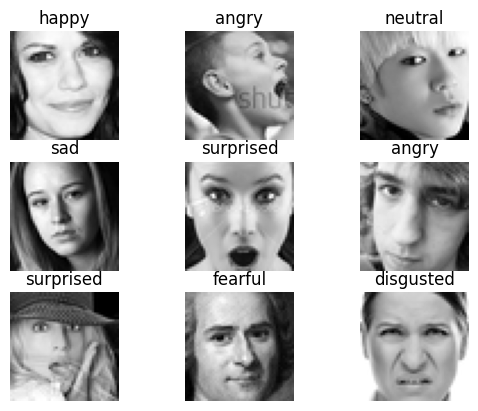

In [13]:
image_batch, label_batch = next(iter(train_ds))

for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray')
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [14]:
num_classes = 7

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=[48, 48, 1]),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [15]:
model.compile(
    optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [16]:
%load_ext tensorboard

In [17]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [18]:
model.fit(train_ds, validation_data=val_ds, epochs = 5, callbacks=[tensorboard_callback])

Epoch 1/5


718/718 [==============================] - 147s 199ms/step - loss: 1.6937 - accuracy: 0.3245 - val_loss: 1.5476 - val_accuracy: 0.4003
Epoch 2/5
718/718 [==============================] - 61s 85ms/step - loss: 1.4771 - accuracy: 0.4328 - val_loss: 1.4437 - val_accuracy: 0.4480
Epoch 3/5
718/718 [==============================] - 65s 91ms/step - loss: 1.3755 - accuracy: 0.4735 - val_loss: 1.3869 - val_accuracy: 0.4719
Epoch 4/5
718/718 [==============================] - 63s 87ms/step - loss: 1.2959 - accuracy: 0.5058 - val_loss: 1.3400 - val_accuracy: 0.4893
Epoch 5/5
718/718 [==============================] - 61s 85ms/step - loss: 1.2366 - accuracy: 0.5293 - val_loss: 1.2983 - val_accuracy: 0.5090


In [19]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 4640), started 0:40:40 ago. (Use '!kill 4640' to kill it.)

In [20]:
!kill 5876

'kill' is not recognized as an internal or external command,
operable program or batch file.
